In [1]:
# !pip install pycocotools

%load_ext autoreload
%autoreload 
%matplotlib inline


from torchvision.datasets import CocoDetection
import torch.utils.data as data
import torch.utils.data as data
from PIL import Image
import os
import os.path
from albumentations import Resize, Compose

from retinanet.retinanet import RetinaNet

from torchvision import transforms
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)
import json
import torch
import numpy as np 
from torchvision.transforms import ToTensor


import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 10]
from torch.utils.data import Dataset
from retinanet.encoder import DataEncoder
import imgaug as ia
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss
from pikachu_dataset import load_data_pikachu
from torch import nn

device  = 'cuda' if torch.cuda.is_available() else 'cpu'

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
N_EPOCHS = 10
BATCH_SIZE = 32
IMAGE_SIZE = 32

image_transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])


class CocoDetection(data.Dataset):

    def __init__(self, root, annFile, transform=None, target_transform=None):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.imw = 256
        self.imh = 256
        self.ids = list(self.coco.imgs.keys())
        self.aug = get_aug([Resize(256, 256)])
        self.encoder = DataEncoder()
#         self.encoder.anchor_areas =[8*8.,16*16.,32*32]


    def __getitem__(self, index):
  
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        
        
        annot = {'image': np.array(img), 
                 'bboxes': [b['bbox'] for b in target], 
                 'category_id':[b['category_id'] for b in target]}
    
        
        annot = self.aug(**annot)
        
        
        boxes = torch.Tensor(annot['bboxes'])
        labels = torch.Tensor(annot['category_id'])
        
        
        
        if boxes.shape[0] == 0:
            return self[index + 1]
            import pdb
            pdb.set_trace()
        if sum(labels>0) == 0:
            
            import pdb 
            pdb.set_trace()
            return self[index + 1]

        
        boxes = torch.cat([boxes[:, :2], boxes[:, :2] + boxes[:, 2:]], dim=1)
        encoded = self.encoder.encode(boxes, labels, torch.Tensor([256, 256]))
        
        how_many_encoded = (encoded[1]>0).sum()
        if  how_many_encoded <= 0:
            print(how_many_encoded)
            print("skipping")
            print(labels)
            return self[index + 1]
        
        return image_transform_train(annot['image']), encoded
    
    


    def __len__(self):
        return len(self.ids)
    
    
def get_aug(aug, min_area=0., min_visibility=0.):
        return Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 
                                         'min_visibility': min_visibility, 
                                         'label_fields': ['category_id']})




    
ds = CocoDetection(root='/media/i008/ssd500/val2017',
                   annFile='/media/i008/ssd500/annotations/instances_val2017.json',
                   
                  )




dl = torch.utils.data.DataLoader(ds, batch_size=8)

def init_weights_retina(module, pi=0.02):
    if hasattr(module, 'name'):
        b = -log((1 - pi) / pi)
        if module.name == 'final_layer':
            module.bias.data.fill_(b)
        elif module.name == 'head_layer':
            module.weight.data.normal_(0, pi)
            module.bias.data.fill_(0)


/home/i008/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


In [2]:
# model= SimpleSSD(100)
model = RetinaNet(100)
# model.freeze_bn()
# for param in model.fpn.parameters():
#     param.requires_grad = False

model = model.to(device)
criterion = FocalLoss(num_classes=100)


optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
collect = []

model = model.apply(init_weights_retina)


In [ ]:

for epoch in range(10):
    for b in dl:
        optimizer.zero_grad()
        image, (bounding_boxes, labels) = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        optimizer.step()
        print(total_loss)



/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loc_loss: 0.069 | cls_loss: 0.008 | tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.065 | cls_loss: 0.010 | tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.058 | cls_loss: 0.009 | tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.052 | cls_loss: 0.007 | tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0)
skipping
tensor([21., 21., 21.])
loc_loss: 0.047 | cls_loss: 0.006 | tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.060 | cls_loss: 0.007 | tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.059 | cls_loss: 0.010 | tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.054 | cls_loss: 0.006 | tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.059 | cls_loss: 0.008 | tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.057 | cls_loss: 0.015 | tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0)
skipping
tensor([ 1.,  1., 

loc_loss: 0.061 | cls_loss: 0.009 | tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.054 | cls_loss: 0.008 | tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.058 | cls_loss: 0.007 | tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.069 | cls_loss: 0.010 | tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.054 | cls_loss: 0.008 | tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.065 | cls_loss: 0.011 | tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.064 | cls_loss: 0.015 | tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.056 | cls_loss: 0.008 | tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.060 | cls_loss: 0.008 | tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.055 | cls_loss: 0.008 | tensor(0.0629, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.064 | cls_loss: 0.010 | tensor(0.0746, device='cuda:0', grad_fn=<Add

loc_loss: 0.046 | cls_loss: 0.005 | tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.060 | cls_loss: 0.011 | tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.056 | cls_loss: 0.006 | tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0)
skipping
tensor([ 1., 34.])
loc_loss: 0.057 | cls_loss: 0.009 | tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.046 | cls_loss: 0.004 | tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.050 | cls_loss: 0.009 | tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.050 | cls_loss: 0.004 | tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.053 | cls_loss: 0.009 | tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)
loc_loss: 0.056 | cls_loss: 0.008 | tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0)
skipping
tensor([ 1., 38.])
tensor(0)
skipping
tensor([16., 16., 16., 16., 16., 16.,  9.,  9.,  9., 16., 16., 16., 85.,  9.]

In [4]:
it = iter(dl)
# model = model.eval()


/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


failed in nnms
tensor([1])


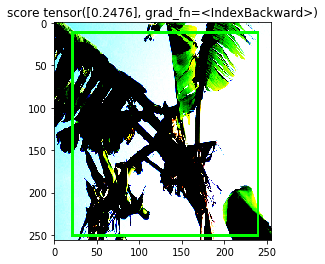

In [26]:
b = next(it)
i = 0
image, (bounding_boxes, labels) = b


loc_pred, cls_pred = model(image.cuda())

bbspred, labelpred, score  = ds.encoder.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

image_to_show = np.moveaxis(
    image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(score))
print(labelpred)

In [46]:
cls_pred.sigmoid()[0].max()

tensor(0.3648, device='cuda:0', grad_fn=<MaxBackward1>)

In [4]:
torch.__version__

'1.0.0'